### Extracting the individual clauses and labels

In [1]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install 'accelerate>=0.26.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import json

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset



In [3]:
# Data Loading Function
def load_clauses_data(data_dir):
    """
    Load clauses data from the specified directory
    Parameters:
        data_dir (str): Path to the directory containing service folders
    Returns:
        list: List of dictionaries containing clause data
    """
    all_clauses = []

    for service_folder in os.listdir(data_dir):
        service_path = os.path.join(data_dir, service_folder)

        if not os.path.isdir(service_path):
            continue

        clauses_file = os.path.join(service_path, 'clauses.json')
        if not os.path.exists(clauses_file):
            continue

        try:
            with open(clauses_file, 'r', encoding='utf-8') as f:
                data = json.load(f)

            if 'clauses' not in data or not data['clauses']:
                print(f"⚠️ WARNING: 'clauses' list is empty in '{service_folder}/clauses.json'")
                continue

            for clause in data['clauses']:
                if not all(key in clause for key in ['clause_text', 'description', 'rating']):
                    print(f"⚠️ WARNING: Skipping a clause in '{service_folder}' due to missing required fields")
                    continue

                clause_data = {
                    'service': service_folder,
                    'clause_text': clause['clause_text'],
                    'description': clause['description'],
                    'rating': clause['rating']
                }
                all_clauses.append(clause_data)

        except Exception as e:
            print(f"Error processing {service_folder}: {str(e)}")

    return all_clauses

In [4]:
rating_map = {
    'good': 0,
    'neutral': 1,
    'bad': 2,
    'blocker': 3,
}

In [5]:
DATA_DIR = "CS224-TC/data_all_202503120623106"
if not os.path.exists(DATA_DIR):
    print(f"Directory '{DATA_DIR}' not found. Cloning repository...")
    # Remove existing directory if it exists
    !rm -rf CS224-TC
    # Clone the repository
    !git clone --depth 1 --filter=blob:none https://github.com/AI-knows-your-rights/CS224-TC.git
else:
    print(f"Directory '{DATA_DIR}' already exists. Skipping cloning.")

# !git clone --depth 1 --filter=blob:none --no-checkout https://github.com/AI-knows-your-rights/CS224-TC.git
# Enable sparse-checkout
#!git sparse-checkout init --cone
# Specify the folder you want to checkout (e.g., "your_folder")
#!git sparse-checkout set data_all_202503120623106


Directory 'CS224-TC/data_all_202503120623106' not found. Cloning repository...
Cloning into 'CS224-TC'...
remote: Enumerating objects: 2469, done.
remote: Counting objects: 100% (2469/2469), done.
remote: Compressing objects: 100% (2387/2387), done.
remote: Total 2469 (delta 318), reused 1810 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (2469/2469), 766.57 KiB | 3.17 MiB/s, done.
Resolving deltas: 100% (318/318), done.
remote: Enumerating objects: 21294, done.
remote: Counting objects: 100% (21294/21294), done.
remote: Compressing objects: 100% (4270/4270), done.
remote: Total 21294 (delta 17736), reused 20481 (delta 17016), pack-reused 0 (from 0)
Receiving objects: 100% (21294/21294), 124.80 MiB | 9.69 MiB/s, done.
Resolving deltas: 100% (17736/17736), done.
Updating files: 100% (27233/27233), done.
Filtering content: 100% (3/3), 1.22 GiB | 21.70 MiB/s, done.


In [6]:
# Load and prepare the dataset
clauses_data = load_clauses_data(DATA_DIR)
df = pd.DataFrame(clauses_data)

# Convert ratings to numerical values
df['rating'] = df['rating'].map(rating_map)
print("\nRating distribution after conversion:")
print(df['rating'].value_counts().sort_index())

# Split into training and testing sets

training_size = round(df.shape[0] * 0.8)

train_df, test_df = train_test_split(df, train_size=training_size, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")
print("\nRating distribution in training set:")
print(train_df['rating'].value_counts().sort_index())

⚠️ WARNING: 'clauses' list is empty in 'Kink.com/clauses.json'

Rating distribution after conversion:
rating
0    2606
1    4072
2    2896
3     219
Name: count, dtype: int64
Training set size: 7834
Testing set size: 1959

Rating distribution in training set:
rating
0    2080
1    3258
2    2328
3     168
Name: count, dtype: int64


### BERT

In [7]:
model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


GPU Available: True
Using GPU: Tesla T4


In [9]:
# Move model to GPU if available
model = model.to(device)

In [10]:
# Define tokenization function

def tokenize_function(examples):
    # Convert the input to a list of strings and ensure it's properly formatted
    texts = [str(text) for text in examples["clause_text"]]  # Ensure text is string

    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors=None  # Important: keep this as None for batched processing
    )


In [11]:
def prepare_dataset(df):
    return Dataset.from_pandas(df)

train_raw_data = prepare_dataset(train_df)
test_raw_data = prepare_dataset(test_df)

In [12]:
print(train_raw_data)

print("Dataset features:", train_raw_data.features)
print("Sample row:", train_raw_data[0])


train_dataset = train_raw_data.map(tokenize_function, batched=True)
test_dataset = test_raw_data.map(tokenize_function, batched=True)

columns_to_remove = ['service', 'clause_text', 'description']
train_dataset = train_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)
train_dataset = train_dataset.rename_column('rating', 'labels')
test_dataset = test_dataset.rename_column('rating', 'labels')

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])


Dataset({
    features: ['service', 'clause_text', 'description', 'rating', '__index_level_0__'],
    num_rows: 7834
})
Dataset features: {'service': Value(dtype='string', id=None), 'clause_text': Value(dtype='string', id=None), 'description': Value(dtype='string', id=None), 'rating': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None)}
Sample row: {'service': 'National Geographic', 'clause_text': 'You may download Course Content identified as available for download only for your own personal, non-commercial use.', 'description': "Users can't use the Service for commercial purposes (unless the Service consents): it is only for personal, individual purposes.", 'rating': 1, '__index_level_0__': 8183}


Map:   0%|          | 0/7834 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/1959 [00:00<?, ? examples/s]

In [13]:
# Define metrics for evaluation
import torch.nn.functional as F

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Convert labels to PyTorch tensor before applying one_hot
    labels = torch.tensor(labels, dtype=torch.int64)
    labels = F.one_hot(labels, num_classes=4).float()  # Convert to one-hot and float

    # predictions = predictions.squeeze()
    predictions = torch.tensor(predictions).float()
    mse = ((predictions - labels) ** 2).mean()
    rmse = np.sqrt(mse.item()) # Convert mse to a python number for numpy

    # predicted_class = torch.argmax(predictions, dim=1)

    rmse = np.sqrt(mse)
    return {
        "mse": mse.item(), # Convert mse to a python number for json serialization
        "rmse": rmse
    }




In [14]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    no_cuda=False,  # Enable GPU
    fp16=True,
    metric_for_best_model="eval_loss",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# To track the training
!pip install weave
!wandb login


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.6 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rayhu007 (rayhu007-stanford) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
# Initialize trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop after 3 epochs of no improvement
    # run_name="ray-legal-bert-classification",
)

In [17]:
print(train_dataset)

Dataset({
    features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7834
})


In [18]:
from transformers import get_scheduler

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataset) * 3,  # 3 epochs
)

In [19]:
# Start training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rayhu007 (rayhu007-stanford) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.925600,0.612325,1.897713,1.377575
2,0.499900,0.564635,3.248268,1.802295
3,0.310000,0.573450,4.170199,2.042106


TrainOutput(global_step=2940, training_loss=0.5359754860806627, metrics={'train_runtime': 761.5691, 'train_samples_per_second': 30.86, 'train_steps_per_second': 3.86, 'total_flos': 6183747063816192.0, 'train_loss': 0.5359754860806627, 'epoch': 3.0})

In [20]:
# Evaluate the model on test set
test_results = trainer.evaluate()
print("\nTest Results:")
print(test_results)

# Function to predict ratings for new clauses

def predict_rating(clause_text):
    # Check if clause_text is None and handle it gracefully
    if clause_text is None:
        print("Warning: Encountered a None clause_text. Returning -1.")  # Or any other default value
        return -1  # Or any other default value

    inputs = tokenizer(
        clause_text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.squeeze()

    predicted_class = torch.argmax(predictions).item()
    return predicted_class

# Test prediction with a sample clause
sample_clause = test_df['clause_text'].iloc[0]
predicted_rating = predict_rating(sample_clause)
actual_rating = test_df['rating'].iloc[0]

print("\nSample Prediction:")
print(f"Predicted Rating: {predicted_rating:.2f}")
print(f"Actual Rating: {actual_rating}")


Test Results:
{'eval_loss': 0.5646353960037231, 'eval_mse': 3.248267889022827, 'eval_rmse': 1.802295207977295, 'eval_runtime': 15.2529, 'eval_samples_per_second': 128.435, 'eval_steps_per_second': 16.063, 'epoch': 3.0}

Sample Prediction:
Predicted Rating: 0.00
Actual Rating: 3


In [21]:

# Evaluate the model on the entire test dataset
predictions = trainer.predict(test_dataset)

# Access predicted labels and metrics
predicted_labels = np.argmax(predictions.predictions, axis=1)
metrics = predictions.metrics

print("\nTest Results (Full Dataset):")
print(metrics)

correct_predictions = np.sum(predicted_labels == test_df['rating'])
total_predictions = len(test_df)
accuracy = correct_predictions / total_predictions

print(f"\nOverall Accuracy: {accuracy:.2f}")




Test Results (Full Dataset):
{'test_loss': 0.5646353960037231, 'test_mse': 3.248267889022827, 'test_rmse': 1.802295207977295, 'test_runtime': 15.3742, 'test_samples_per_second': 127.421, 'test_steps_per_second': 15.936}

Overall Accuracy: 0.81


In [22]:
# Predict ratings for all samples in test_df and compare with actual ratings
for index in range(len(test_df)):
    sample_clause = test_df['clause_text'].iloc[index]  # Get the clause text
    predicted_rating = predict_rating(sample_clause)   # Predict the rating
    actual_rating = test_df['rating'].iloc[index]     # Get the actual rating

    print(f"\nSample Prediction ({index + 1}): {sample_clause}")
    print(f"Predicted Rating: {predicted_rating}")
    print(f"Actual Rating: {actual_rating}")

Streaming output truncated to the last 5000 lines.
          
        
    
  
        
          
              Version 3: 2019-06-24 05:15:33 UTC by skylarmt (713)  Curator
          
        
        
          
            
              Analysis updated
            
          
        
        
          
              
          
        
    
          
              Version 3: 2019-06-24 05:15:33 UTC by skylarmt (713)  Curator
          
        
          
            
              Analysis updated
            
          
        
          
              
          
        
      
        
          
            Previous Title: No changes recorded
            Updated Title: No changes recorded
          
          
            Previous Analysis: No changes recorded
            Updated Analysis: No changes recorded
          
          
            Previous Status:  CHANGES REQUESTED
            Updated Status:  PENDING
          
        
      
    
        
          
   

In [23]:
# Evaluate the model on the test dataset
results = trainer.evaluate()

# Print out the evaluation results
print(results)


{'eval_loss': 0.5646353960037231, 'eval_mse': 3.248267889022827, 'eval_rmse': 1.802295207977295, 'eval_runtime': 14.4928, 'eval_samples_per_second': 135.17, 'eval_steps_per_second': 16.905, 'epoch': 3.0}


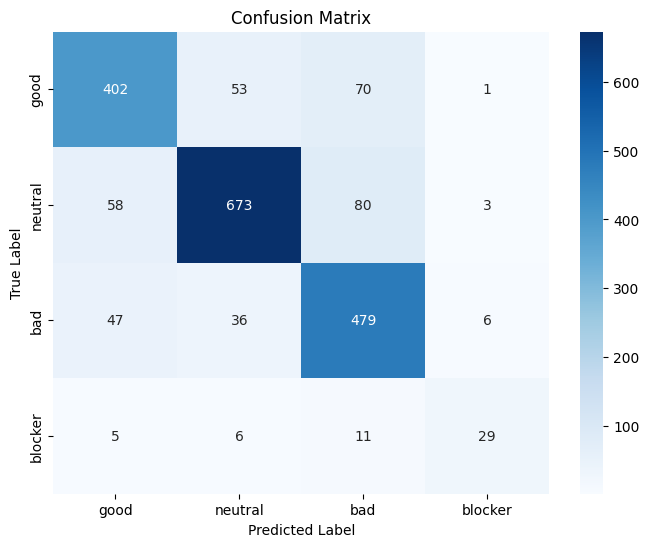

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and true labels
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)  # For multi-class classification
true_labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["good", "neutral", "bad", "blocker"], yticklabels=["good", "neutral", "bad", "blocker"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [57]:
import spacy
nlp = spacy.load("en_core_web_sm") #, disable=["parser", "ner"])
nlp.max_length = 1500000

def load_tc_document(tc_files):
    all_sentences = []
    for doc_path in tc_files:
        with open(doc_path, 'r', encoding='utf-8') as file:
            text = file.read()
        # A basic clause extraction logic, for example, assuming each clause ends with a period
        # clauses = sent_tokenize(text)
        doc = nlp(text)
        doc_sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]

        all_sentences.extend( [sentence.strip() for sentence in doc_sentences if sentence.strip()])
    return all_sentences

In [82]:
# !pip install transformers sentence-transformers sklearn
# from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the pre-trained model (Sentence-BERT)
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
clause_texts = [clause['clause_text'] for clause in clauses_data if clause.get('clause_text') and clause['clause_text'].strip()]
clauses_embeddings = similarity_model.encode(clause_texts)

def sentences_to_clauses(sentences, threshold=0.9):
    results = []

    for sentence in sentences:
        # Generate embedding for the current sentence
        sentence_embedding = similarity_model.encode([sentence])

        # Compute cosine similarities between the sentence and all known clauses
        similarities = cosine_similarity(sentence_embedding, clauses_embeddings)

        # Find the highest similarity score
        max_similarity = np.max(similarities)

        # If the similarity score is above the threshold, consider it a valid clause
        if max_similarity > threshold:
            results.append({
                "sentence": sentence,
                "is_clause": True,
                "similarity": max_similarity
            })
        else:
            results.append({
                "sentence": sentence,
                "is_clause": False,
                "similarity": max_similarity
            })
    clause_count = len([result for result in results if result['is_clause']])
    print(f"Total sentences: {len(sentences)}")
    print(f"Total clauses: {clause_count}")
    return results


In [62]:
# Predict clause rating using the pre-trained model
def predict_clause_rating(clause_text):
    # Tokenize the clause and convert it into input format for the model
    inputs = tokenizer(clause_text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Convert the predicted class to a rating
    if predicted_class == 0:
        return "good"
    elif predicted_class == 1:
        return "neutral"
    elif predicted_class == 2:
        return "bad"
    elif predicted_class == 3:
        return "blocker"

In [77]:
# Calculate the document grade based on clause scores
def calculate_website_grade(website, tc_files, actual_grade):

    sentences  = load_tc_document(tc_files)
    clauses = sentences_to_clauses(sentences)
    # Initialize counts for good, bad, and blocker clauses
    good_count = 0
    bad_count = 0
    blocker_count = 0

    # Loop through each clause and predict its rating
    for clause in clauses:
        # print('checking clause:')
        # print(clause)
        if clause.get('is_clause') and clause['is_clause']:
            rating = predict_clause_rating(clause['sentence'])
            if rating == "good":
                good_count += 1
            elif rating == "bad":
                bad_count += 1
            elif rating == "blocker":
                blocker_count += 1

    # Calculate the score: good - bad - 3 * blocker
    score = good_count - bad_count - 3 * blocker_count

    # Determine the grade based on the score
    if good_count + bad_count + blocker_count == 0:
        grade = 'N/A'
    elif score <= -10 or blocker_count > good_count:
        grade = 'E'
    elif blocker_count >= 3 or bad_count > good_count:
        grade = 'D'
    elif score < 5:
        grade = 'C'
    elif bad_count > 0:
        grade = 'B'
    else:
        grade = 'A'
    print(f"{website} graded as {grade}, actual grade is: {actual_grade}")
    return {
        "website": website,
        "score": score,
        "predicted_grade": grade,
        "actual_grade": actual_grade,
        "good_count": good_count,
        "bad_count": bad_count,
        "blocker_count": blocker_count
    }


In [68]:
# Function to process all documents in subfolders
def process_websites(folder_path):
    results = []

    # Loop through each website subfolder
    for subfolder in os.listdir(folder_path):
        print(f"Processing folder: {subfolder}")
        details_path = os.path.join(folder_path, subfolder, 'details.json')
        with open(details_path, 'r') as f:
            details = json.load(f)
            if 'rating' in details:
                actual_grade = details['rating']
        documents_folder = os.path.join(folder_path, subfolder, 'documents')
        # loop through all the TXT files in the documents folder
        for _, _, files in os.walk(documents_folder):
            tc_files = []
            for file in files:
                if file.endswith('.txt') and file.startswith('TC'):  # Process only TC_xx.txt files
                    doc_path = os.path.join(documents_folder, file)
                    tc_files.append(doc_path)
        # calculate the website grade based
        result = calculate_website_grade(subfolder, tc_files, actual_grade)
        results.append(result)

    return results

In [83]:
results = process_websites(DATA_DIR)

# Print the results
for result in results:
    print(f"Website: {result['website']}, Score: {result['score']}, Predicted Grade: {result['predicted_grade']}, Actual Grade: {result['actual_grade']}")


Processing folder: MobyGames
Total sentences: 463
Total clauses: 12
MobyGames graded as C, actual grade is: D
Processing folder: Linguee
Total sentences: 1161
Total clauses: 38
Linguee graded as A, actual grade is: C
Processing folder: zmudzinski.me Personal Blog (DEPRECATED)
Total sentences: 1161
Total clauses: 38
zmudzinski.me Personal Blog (DEPRECATED) graded as A, actual grade is: A
Processing folder: Healthline
Total sentences: 979
Total clauses: 0
Healthline graded as N/A, actual grade is: E
Processing folder: GoDaddy
Total sentences: 4848
Total clauses: 36
GoDaddy graded as D, actual grade is: D
Processing folder: Rumble
Total sentences: 2433
Total clauses: 67
Rumble graded as B, actual grade is: D
Processing folder: CNN
Total sentences: 8
Total clauses: 0
CNN graded as N/A, actual grade is: E
Processing folder: Liberapay
Total sentences: 0
Total clauses: 0
Liberapay graded as N/A, actual grade is: B
Processing folder: Represent
Total sentences: 0
Total clauses: 0
Represent grad

KeyboardInterrupt: 